# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: `Бадло Владимир Владимирович`

Группа: `DS-11`

In [298]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, mapping, shape, MultiPolygon
from shapely import wkt, geometry
import earthpy as et 
import folium
from folium.features import DivIcon
from random import randint
from haversine import haversine

from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from OSMPythonTools.api import Api
import osmapi as osm

import json
import requests
import warnings

import pyproj
from openrouteservice import client

warnings.filterwarnings("ignore")
%matplotlib inline

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<AxesSubplot:>

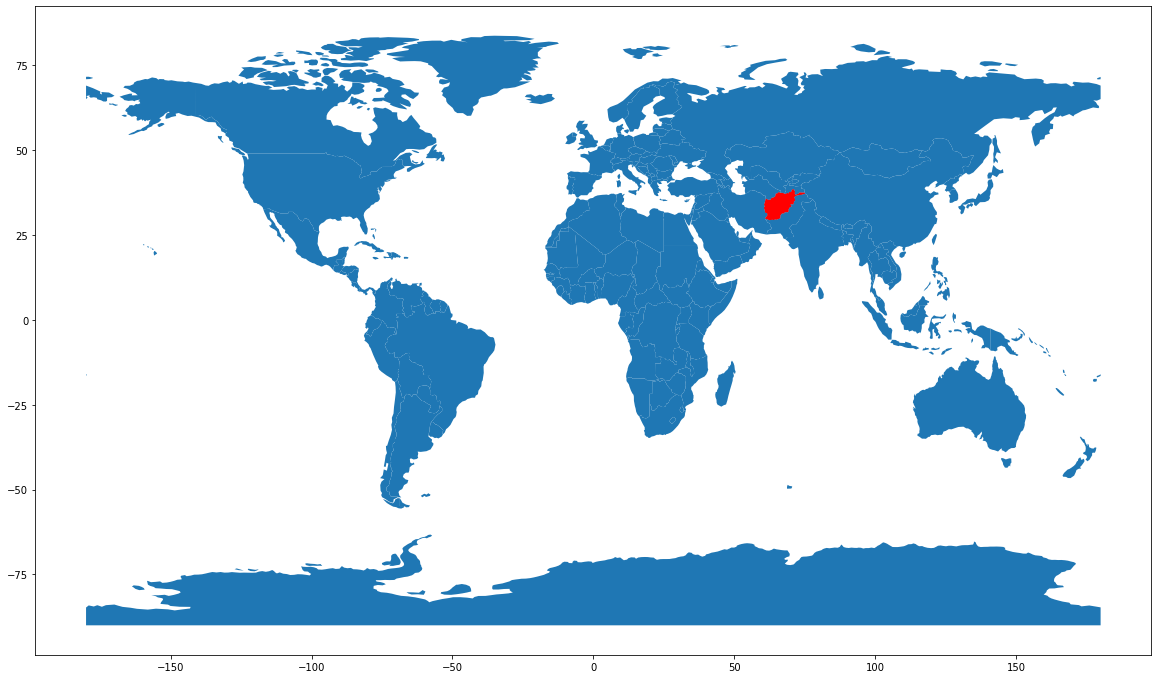

In [3]:
fig, ax = plt.subplots(figsize=[20,20])
world.plot(ax=ax)
cond = world['name'] == 'Afghanistan'
world[cond].plot(ax=ax, color='r')

<AxesSubplot:>

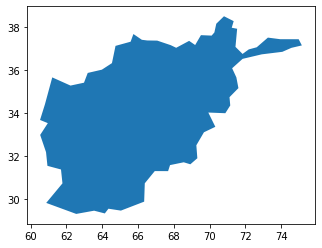

In [14]:
cond = world['name'] == 'Afghanistan'
world[cond].plot()

In [5]:
#1
#выделим полигон афганистана в отдельную переменную
cond = world['name'] == 'Afghanistan'
afgan_poly = world[cond].geometry.values[0]

# будем генерировать точки пока не попадаем в Афганистан:
rand_points = []
min_x = world.crs.area_of_use.west
max_x = world.crs.area_of_use.east
min_y = world.crs.area_of_use.south
max_y = world.crs.area_of_use.north

while True:
    point = Point(randint(min_x, max_x), randint(min_y, max_y))
    rand_points.append(point)
#     print(point)
    if point.within(afgan_poly):
        break
print(f'Coordinate: {rand_points[-1]}')
print(f'Last point within Afganistan borders: {rand_points[-1].within(afgan_poly)}')

Coordinate: POINT (68 37)
Last point within Afganistan borders: True


Попробуем искать умнее.    
Будем делить область поиска на две равные части, 
ставить в каждой области точку в середине и проверять расстояние от этих точек до центра Афганистана.    
Далее, будем оставлять ту область, для которой расстояние от центральной точки до центра Афганистана оказалось короче (если равны, то любую). 

In [6]:
afgan_center = afgan_poly.centroid.coords[:][0]

min_x = world.crs.area_of_use.west
max_x = world.crs.area_of_use.east
min_y = world.crs.area_of_use.south
max_y = world.crs.area_of_use.north

algo_coords = []
while True:
    if abs(max_x - min_x) >= abs(max_y - min_y):
        x_line = (max_x + min_x)/2
        center_left = Point((min_x + x_line)/2, (max_y + min_y) / 2)
        center_right = Point((x_line + max_x)/2, (max_y + min_y) / 2)
        if haversine(center_left.coords[:][0], afgan_center) >= haversine(center_right.coords[:][0], afgan_center):
            min_x = x_line
            nearest_point = center_right
        else:
            max_x = x_line
            nearest_point = center_left
        print(nearest_point)
    else:
        y_line = (max_y + min_y) / 2
        center_up = Point((max_x + min_x) / 2, (max_y + y_line) / 2)
        center_down = Point((max_x + min_x)/2, (min_y + y_line) / 2)
        if haversine(center_down.coords[:][0], afgan_center) >= haversine(center_up.coords[:][0], afgan_center):
            min_y = y_line
            nearest_point = center_up
        else:
            max_y = y_line
            nearest_point = center_down
        print(nearest_point)

    algo_coords.append(nearest_point)
    if nearest_point.within(afgan_poly):
        break
print(nearest_point)

POINT (90 0)
POINT (45 0)
POINT (45 45)
POINT (67.5 45)
POINT (67.5 22.5)
POINT (56.25 22.5)
POINT (56.25 33.75)
POINT (61.875 33.75)
POINT (61.875 33.75)


In [299]:
print(algo_coords[-1])

POINT (61.875 33.75)


Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``.        

Обозначим появляение каждой точки на карте через порядковый номер.

In [300]:
m = folium.Map(
    location=[0, 0],
    zoom_start = 2,
)

for i, point in enumerate(algo_coords):
    folium.Marker(
        location=point.coords[:][0][::-1],
        popup=f'coordinate {i}: {point}',
#         icon=folium.Icon(icon='cloud'),
        icon=DivIcon(icon_size=(150,36), 
                     icon_anchor=(5,5),
                     html='<div style="font-size: 10pt; color : red;">{}</div>'.format(i))
    ).add_to(m)
m

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [63]:
# загрузим все areaId стран
from collections import defaultdict
overpass = Overpass()
countries = overpass.query(
    """
    rel[admin_level=2]
       [type=boundary]
       [boundary=administrative];
    out;
    """)
countries_id = defaultdict(str)
for c in countries.elements():
    if str(c.id())[-1] == '0':
        try:
            countries_id[c.tags()['name:en']] = c.id()
        except:
            print(c.id())

In [64]:
countries_id

defaultdict(str,
            {'Brazil': 59470,
             'Estonia': 79510,
             'Australia': 80500,
             'Eswatini': 88210,
             'Bangladesh': 184640,
             'Syria': 184840,
             'Liberia': 192780,
             'Central African Republic': 192790,
             'Ethiopia': 192800,
             'Cameroon': 192830,
             'Tanzania': 195270,
             'Malawi': 195290,
             'Uzbekistan': 196240,
             'Honduras': 287670,
             'Portugal': 295480,
             'Azerbaijan': 364110,
             'Taiwan': 449220,
             'Comoros': 535790,
             'São Tomé and Príncipe': 535880,
             'Singapore': 536780,
             'Antigua and Barbuda': 536900,
             'Kosovo': 2088990,
             'Brunei': 2103120,
             'Tokelau': 2186600,
             'Norway': 2978650})

In [75]:
# найдем страну с наибольшим количеством объектов недвижимости
property_by_country = defaultdict(str)
for country, area_id in countries_id.items():
    area_id = 3600000000 + area_id
    query = overpassQueryBuilder(area=area_id, elementType=['way'], selector='"landuse"="residential"', out='count')
    result = overpass.query(query, timeout=600).countElements()
    property_by_country[country] = result
    print(country, result)

[overpass] downloading data: [timeout:600][out:json];area(3600059470)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;
[overpass] downloading data: [timeout:600][out:json];area(3600079510)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Brazil 52202


[overpass] downloading data: [timeout:600][out:json];area(3600080500)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Estonia 4958


[overpass] downloading data: [timeout:600][out:json];area(3600088210)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Australia 49994


[overpass] downloading data: [timeout:600][out:json];area(3600184640)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Eswatini 242


[overpass] downloading data: [timeout:600][out:json];area(3600184840)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Bangladesh 49368


[overpass] downloading data: [timeout:600][out:json];area(3600192780)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Syria 15895


[overpass] downloading data: [timeout:600][out:json];area(3600192790)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Liberia 18341


[overpass] downloading data: [timeout:600][out:json];area(3600192800)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Central African Republic 15796


[overpass] downloading data: [timeout:600][out:json];area(3600192830)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Ethiopia 62384


[overpass] downloading data: [timeout:600][out:json];area(3600195270)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Cameroon 138550


[overpass] downloading data: [timeout:600][out:json];area(3600195290)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Tanzania 129165


[overpass] downloading data: [timeout:600][out:json];area(3600196240)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Malawi 16865


[overpass] downloading data: [timeout:600][out:json];area(3600287670)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Uzbekistan 5958


[overpass] downloading data: [timeout:600][out:json];area(3600295480)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Honduras 1033


[overpass] downloading data: [timeout:600][out:json];area(3600364110)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Portugal 19260


[overpass] downloading data: [timeout:600][out:json];area(3600449220)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Azerbaijan 4991


[overpass] downloading data: [timeout:600][out:json];area(3600535790)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Taiwan 9260


[overpass] downloading data: [timeout:600][out:json];area(3600535880)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Comoros 325


[overpass] downloading data: [timeout:600][out:json];area(3600536780)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


São Tomé and Príncipe 404


[overpass] downloading data: [timeout:600][out:json];area(3600536900)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Singapore 2528


[overpass] downloading data: [timeout:600][out:json];area(3602088990)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Antigua and Barbuda 174


[overpass] downloading data: [timeout:600][out:json];area(3602103120)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Kosovo 1679


[overpass] downloading data: [timeout:600][out:json];area(3602186600)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Brunei 81


[overpass] downloading data: [timeout:600][out:json];area(3602978650)->.searchArea;(way["landuse"="residential"](area.searchArea);); out count;


Tokelau 4
Norway 12599


In [82]:
max_property_country = max(property_by_country.items(), key=lambda x: x[1])
max_property_country

('Cameroon', 138550)

In [112]:
# найдем банкоматы Камеруна
area_id = 3600000000 + countries_id[max_property_country[0]]
query = overpassQueryBuilder(area=area_id, elementType=['node'], selector='"amenity"="atm"')
atms = overpass.query(query, timeout=900)
atms = atms.elements()
print(atms[0].geometry())
print(atms[0].tags())

[overpass] downloading data: [timeout:900][out:json];area(3600192830)->.searchArea;(node["amenity"="atm"](area.searchArea);way["amenity"="atm"](area.searchArea);relation["amenity"="atm"](area.searchArea);); out body;


{"coordinates": [9.755581, 4.084525], "type": "Point"}
{'amenity': 'atm', 'name': 'Ecobank', 'operator': 'Ecobank'}


In [133]:
from rtree.index import Rtree

idx = Rtree()

for i, atm in enumerate(atms):
    coord = atm.geometry()['coordinates']
    idx.insert(i, coord * 2)

In [143]:
afgan_point = algo_coords[-1]
poi = list(idx.nearest(afgan_point.bounds, 5))
poi

[4, 12, 7, 6, 5]

In [154]:
afgan_point.coords[:][0]

(61.875, 33.75)

In [292]:
# посмотрим на координаты и расстояние от точки в Афганистане до них
length_to_poi = []
for i in poi:
    coord = atms[i].geometry()['coordinates']
    length_to_poi.append(haversine(coord, afgan_point.coords[:][0]))
    print(coord, length_to_poi[-1])

[13.589851, 7.33836] 5766.4747988451645
[10.903312, 5.731545] 6101.128199026411
[11.629021, 4.356447] 6065.199293453205
[11.51698, 3.873072] 6092.183417978636
[11.52125, 3.862558] 6092.05795319529


## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [301]:
api_key = '5b3ce3597851110001cf6248848c076dd3944ee5b5123aef5854f7b6'

clt = client.Client(key=api_key)

df = pd.read_csv('2019_-_2020_School_Point_Locations.csv')
df.rename(columns={'the_geom': 'geometry'}, inplace=True)
df['geometry'] = df['geometry'].apply(wkt.loads)
# преобразуем в геодатафрейм
gdf = gpd.GeoDataFrame(df, crs='epsg:4326')

In [302]:
# точки начала и конца маршрута
from_ = (-73.9674, 40.7724)
to_ = (-73.9895, 40.7030)

# создадим область для рассмотрения
area_of_route = Polygon(((from_[0], from_[1]),(to_[0], from_[1]),(to_[0], to_[1]),(from_[0], to_[1])))
# расширим область через буфер
area_of_route = area_of_route.buffer(0.0025)

# выберем школы, которые войдут в область
cond = gdf['geometry'].within(area_of_route)
schools_in_area = gdf['geometry'][cond]

def make_buff(point, buff=0.002):
    return point.buffer(buff)

# создадим области, которые будем избегать
schools_with_buff = schools_in_area.apply(make_buff)

params = {'geometry':True, 'format':'geojson',
         'instructions': False, 'preference': 'shortest'}

options = {'avoid_polygons': geometry.mapping(MultiPolygon(polygons=schools_with_buff.values))}

routing = clt.directions((from_, to_), options=options, **params)

In [303]:
#построим нашу карту с маршрутом и зонами школ
ny_map = folium.Map(to_[::-1], zoom_start=12)

folium.features.GeoJson(schools_with_buff).add_to(ny_map)
folium.map.Marker((from_[::-1])).add_to(ny_map)
folium.map.Marker((to_[::-1])).add_to(ny_map)
folium.features.GeoJson(routing).add_to(ny_map)

ny_map